In [1]:
#%matplotlib notebook

In [1]:
from importlib import reload
import two_transmons.DoubleTransmonSystem
from two_transmons.DoubleTransmonSystem import *
import two_transmons.VacuumRabiSimulation
from two_transmons.VacuumRabiSimulation import *
import single_transmon.Transmon
from single_transmon.Transmon import *
from ReadoutResonator import *
from qutip import *
from tqdm.notebook import tqdm
from two_transmons.ZPulse import *
from importlib import reload
import two_transmons.ParallelCalculations
from two_transmons.ParallelCalculations import *
from two_transmons.CalcTime import *
from two_transmons.Tomography import *
from scipy.linalg import cholesky
from p_tqdm import p_map, p_imap
import time
import numpy as np
from numpy import dot

In [2]:
Nc = 7
N_trunc = 3
Ec1 = 0.25 * 2 * np.pi
Ec2 = 1.03*Ec1
Ecc = 0.01/1.2**2 * 2 * np.pi/5 # 1.2 is my estimate for n_{ge} matrix element
Ej1 = Ec1 * 100
Ej2 = Ec2 * 100
d = 0.2

T1_1, T2_1 = 10e6, 5e6
T1_2, T2_2 = 5e6, 1e6

tr1 = Transmon(Ec1, Ej1, d, 1/T1_1, 1/T2_1, Nc, N_trunc, 1)
tr2 = Transmon(Ec2, Ej2, d, 1/T1_2, 1/T2_2, Nc, N_trunc, 2)
dts = DoubleTransmonSystem(tr1, tr2, Ecc)
r = ReadoutResonator(6, 1118, 1964, phi=0.29)
r.set_qubit_parameters(.05, 0.05, 5, 5.3, .2, .2)


freq_lim = 0.2
farg=cook_farg(20,freq_lim)
params=farg[0]['params']
Ts = linspace(0, params["finish"], params['t_points'])
T = Tomography(dts, Ts, params, r)

<ipython-input-2-ce2f8a833dd4>:23: DeprecationWarning: scipy.linspace is deprecated and will be removed in SciPy 2.0.0, use numpy.linspace instead
  Ts = linspace(0, params["finish"], params['t_points'])
C:\ProgramData\Anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


### $ \mid0\rangle\otimes\mid-i\rangle \rightarrow\mid-\rangle\otimes\mid 0 \rangle$
Here we could see the error in phase determination of the $1 st$ qubit 

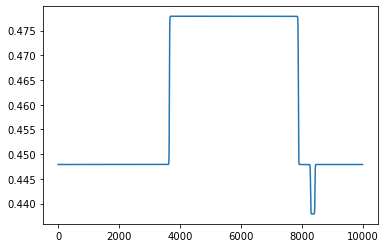

In [3]:
# форма потокового импульса на первый кубит
plot(T.build_waveforms()[0])

C:\ProgramData\Anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


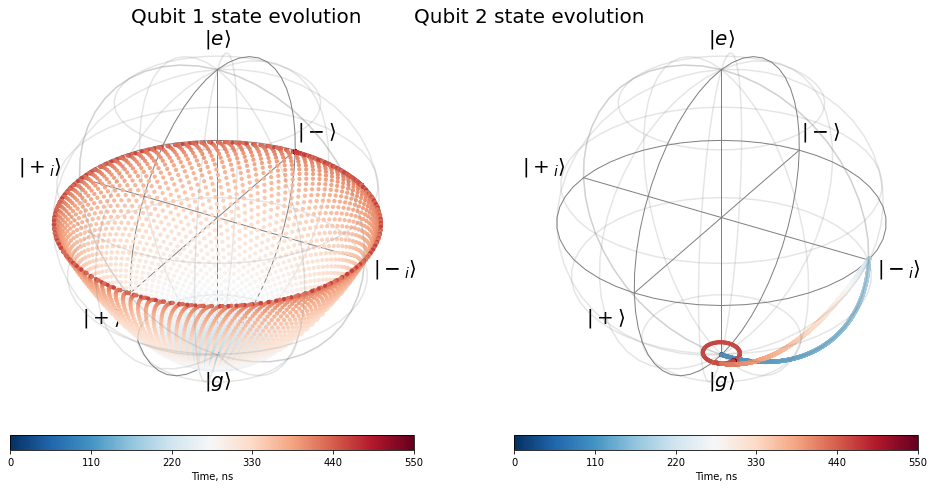

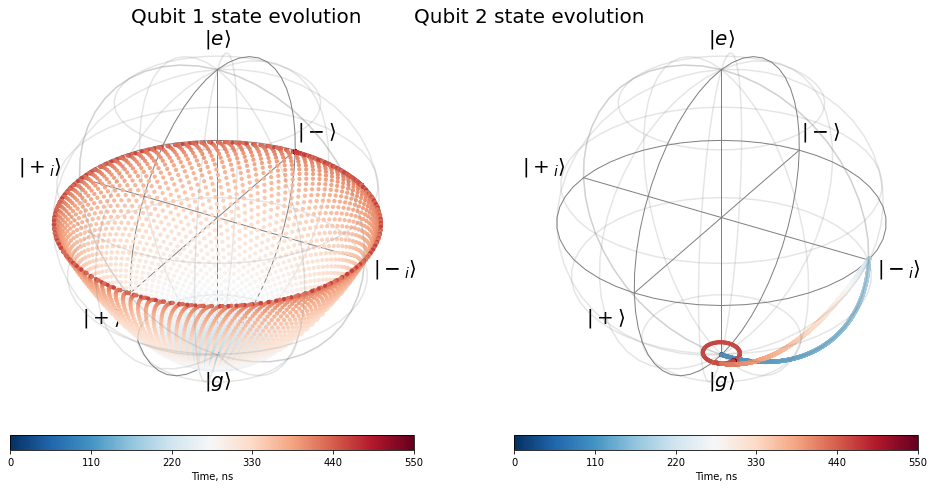

In [4]:
dm = T.run_iswap_test_step_parallel([(0, 0),(T._pi_duration/2,0)], full_output = True).states
Tomography.plot_qubits_dynamic(T,10, dm=dm, interaction = True)

Fidelity = (0.9930505587375397+2.5616030548684107e-12j)


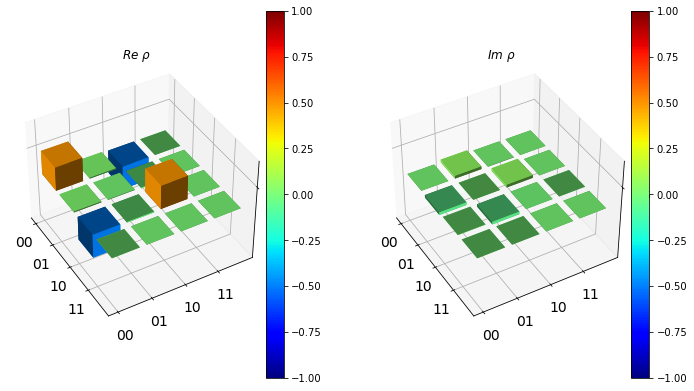

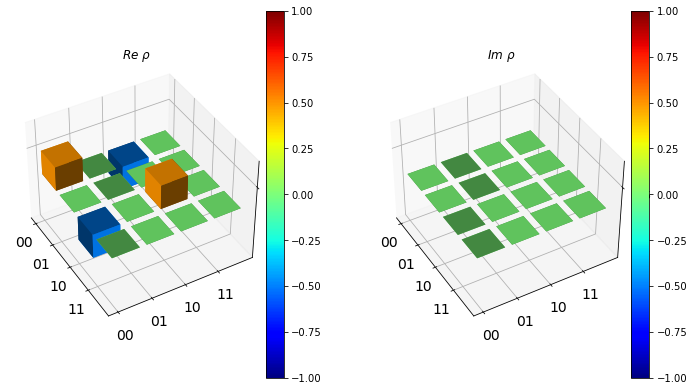

In [11]:
#rho_predicted = Tomography._find_rho_iswap(T,10,dm_final)
rho_predicted =Tomography.rho3dim_to_rho(dm[-1])
Tomography.show_density_matrix(rho_predicted)
rho_ideal = [[1/2,0,-1/2,0],[0,0,0,0],[-1/2,0,1/2,0],[0,0,0,0]]
Tomography.show_density_matrix(rho_ideal)
fidelity = Tomography.state_fidelity(rho_ideal, rho_predicted)
print ('Fidelity =', fidelity)

### $ \mid -i \rangle\otimes\mid 1 \rangle \rightarrow\mid 1 \rangle\otimes\mid + \rangle$
Here we could see the error in phase determination of the $2 nd$ qubit 

C:\ProgramData\Anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Fidelity = (0.9920950640647689-1.9879936948507186e-10j)


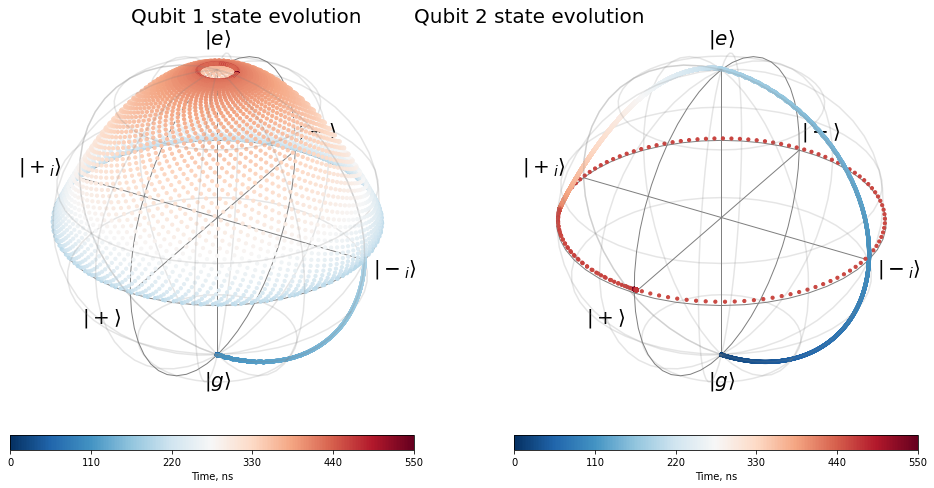

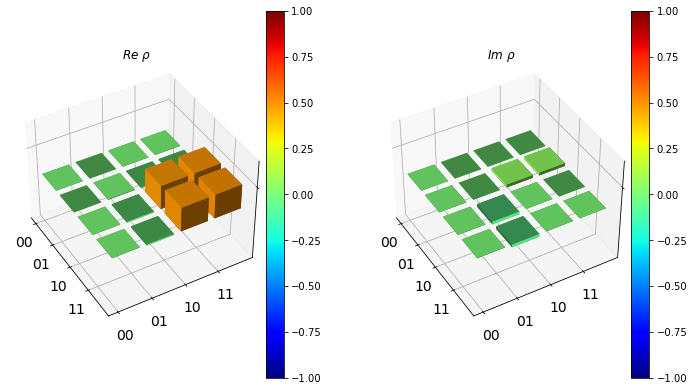

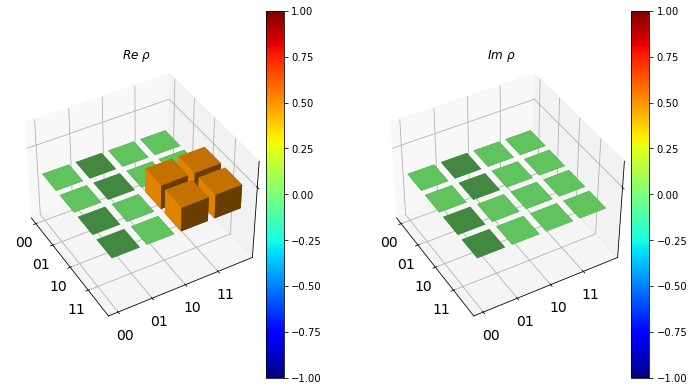

In [12]:
dm = T.run_iswap_test_step_parallel([(T._pi_duration/2, 0),(T._pi_duration,0)], full_output = True).states
Tomography.plot_qubits_dynamic(T,1, dm=dm, interaction = True)
rho_predicted =Tomography.rho3dim_to_rho(dm[-1])
Tomography.show_density_matrix(rho_predicted)
rho_ideal = [[0,0,0,0],[0,0,0,0],[0,0,1/2,1/2],[0,0,1/2,1/2]]
Tomography.show_density_matrix(rho_ideal)
fidelity = Tomography.state_fidelity(rho_ideal, rho_predicted)
print ('Fidelity =', fidelity)

In [13]:
X1, Y1, Z1 = [], [], []
X2, Y2, Z2 = [], [], []
for state in tqdm_notebook(dm, desc = 'Average projections calculation'):
    X1.append(expect(dts.two_qubit_operator(qubit1_operator=dts._tr1.sx()), state))
    Y1.append(expect(dts.two_qubit_operator(qubit1_operator=dts._tr1.sy()), state))
    Z1.append(expect(dts.two_qubit_operator(qubit1_operator=dts._tr1.sz()), state))

    X2.append(expect(dts.two_qubit_operator(qubit2_operator=dts._tr2.sx()), state))
    Y2.append(expect(dts.two_qubit_operator(qubit2_operator=dts._tr2.sy()), state))
    Z2.append(expect(dts.two_qubit_operator(qubit2_operator=dts._tr2.sz()), state))

<ipython-input-13-75cf0040de51>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for state in tqdm_notebook(dm, desc = 'Average projections calculation'):


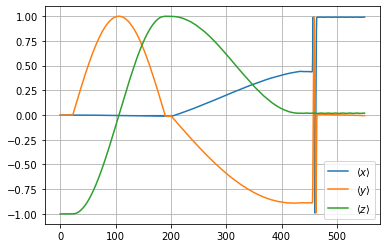

In [14]:
figure()
plot(Ts, X2, label=r"$\langle x\rangle$")
plot(Ts, Y2, label=r"$\langle y\rangle$")
plot(Ts, Z2, label=r"$\langle z\rangle$")
legend()
grid()

## List of fidelities of our 'i-swap' gate

In [ ]:
n = len(T._2q_rotations)
state_fidelities = p_map(Tomography.fidelity_function_zgate, [T]*n, \
                         [T._params["t_zgate"]]*n, [T._params["t_zgate2"]]*n,[T._params["start"]]*n, range(n), num_cpus = 24)

In [ ]:
state_fidelities

## Z gate time calibration

### $1st\ qubit$ 

In [9]:
ts_zgate = 0.2*np.arange(24) + 12
ts_zgate2 = ones_like(ts_zgate)*5.8
t_starts = ones_like(ts_zgate)*T._params['start']
#t_starts = ones_like(ts_zgate)*

#T._params


<ipython-input-9-627bfa1d4ab9>:2: DeprecationWarning: scipy.ones_like is deprecated and will be removed in SciPy 2.0.0, use numpy.ones_like instead
  ts_zgate2 = ones_like(ts_zgate)*5.8
<ipython-input-9-627bfa1d4ab9>:3: DeprecationWarning: scipy.ones_like is deprecated and will be removed in SciPy 2.0.0, use numpy.ones_like instead
  t_starts = ones_like(ts_zgate)*T._params['start']


In [10]:
fidelity_array = p_map(Tomography.fidelity_function_zgate,[T]*len(t_starts), ts_zgate, ts_zgate2, t_starts, 
                        [2]*len(ts_zgate),num_cpus=24)

In [11]:
t1_opt = ts_zgate[argmax(fidelity_array)]
print ('t1 z =', t1_opt, 'fidelity =', max(fidelity_array))

t1 z = 13.6 fidelity = (0.9594789905241312+1.4135573402928348e-16j)


<ipython-input-11-f2b2f6584457>:1: DeprecationWarning: scipy.argmax is deprecated and will be removed in SciPy 2.0.0, use numpy.argmax instead
  t1_opt = ts_zgate[argmax(fidelity_array)]


<IPython.core.display.Javascript object>


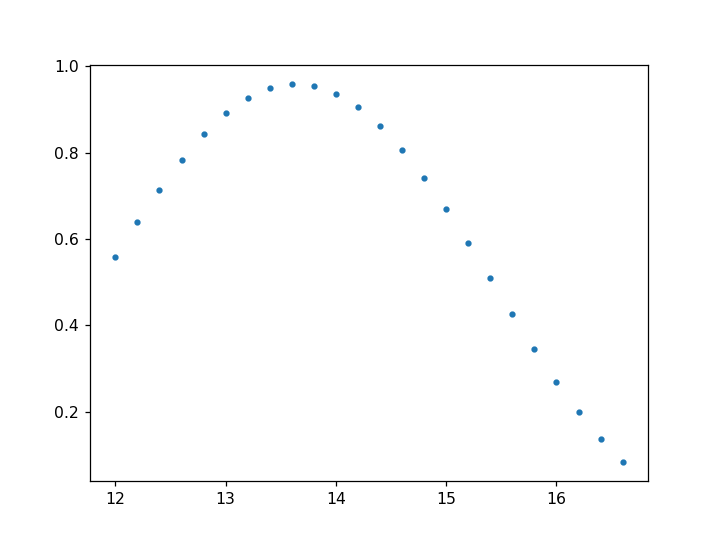

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [12]:
figure()
plot (ts_zgate, fidelity_array, '.')
#ylim (0.58, 0.60)

### $2nd\ qubit$

In [4]:
t1_opt = 13.6
ts_zgate2 = 0.2*np.arange(24) + 5.2
ts_zgate = ones_like (ts_zgate2)*t1_opt
t_starts = ones_like(ts_zgate)*T._params['start']
fidelity_array_2 = p_map(Tomography.fidelity_function_zgate,[T]*len(ts_zgate2), ts_zgate, ts_zgate2, t_starts, 
                        [12]*len(ts_zgate2),num_cpus=24)

<ipython-input-4-f3e11867e0cb>:3: DeprecationWarning: scipy.ones_like is deprecated and will be removed in SciPy 2.0.0, use numpy.ones_like instead
  ts_zgate = ones_like (ts_zgate2)*t1_opt
<ipython-input-4-f3e11867e0cb>:4: DeprecationWarning: scipy.ones_like is deprecated and will be removed in SciPy 2.0.0, use numpy.ones_like instead
  t_starts = ones_like(ts_zgate)*T._params['start']


In [5]:
t2_opt = ts_zgate2 [argmax(fidelity_array_2)]
print ('t2 z =', t2_opt, 'fidelity =', max(fidelity_array_2))
figure()
plot (ts_zgate2, fidelity_array_2, '.')

<ipython-input-5-5178cb1901a1>:1: DeprecationWarning: scipy.argmax is deprecated and will be removed in SciPy 2.0.0, use numpy.argmax instead
  t2_opt = ts_zgate2 [argmax(fidelity_array_2)]


t2 z = 5.2 fidelity = (0.12953734288121277-1.108286516597769e-15j)


<IPython.core.display.Javascript object>

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


### $T_{start}\ dependence $

In [6]:
#t_starts = linspace (290, 290.5, 48)
t_starts = np.arange (48)*(1) + 320
ts_zgate =ones_like(t_starts)*T._params['t_zgate']
ts_zgate2 = ones_like(t_starts)*T._params['t_zgate2']
fidelity_array = p_map(Tomography.fidelity_function_zgate,[T]*len(t_starts), ts_zgate, ts_zgate2, t_starts, 
                        [2]*len(ts_zgate),num_cpus=24)

<ipython-input-6-751648e0e912>:3: DeprecationWarning: scipy.ones_like is deprecated and will be removed in SciPy 2.0.0, use numpy.ones_like instead
  ts_zgate =ones_like(t_starts)*T._params['t_zgate']
<ipython-input-6-751648e0e912>:4: DeprecationWarning: scipy.ones_like is deprecated and will be removed in SciPy 2.0.0, use numpy.ones_like instead
  ts_zgate2 = ones_like(t_starts)*T._params['t_zgate2']


KeyboardInterrupt: 

<IPython.core.display.Javascript object>


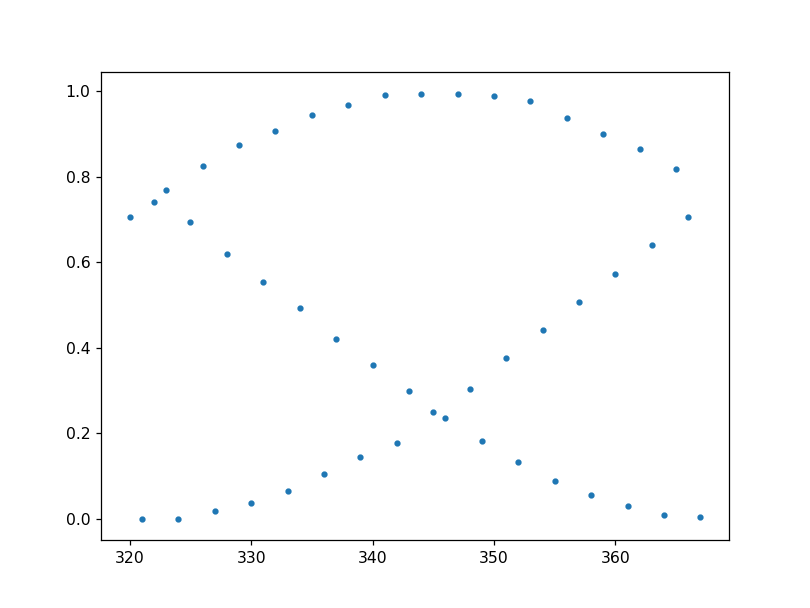

/home/alexeitolstobrov/server/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


In [12]:
figure()
plot (t_starts, fidelity_array, '.')

In [13]:
t_starts[argmax(fidelity_array)]

/tmp/ipykernel_1061639/2775040572.py:1: DeprecationWarning: scipy.argmax is deprecated and will be removed in SciPy 2.0.0, use numpy.argmax instead
  t_starts[argmax(fidelity_array)]


344

In [14]:
max(fidelity_array)

(0.9943265557780453+1.769007051743949e-08j)

In [27]:
T._2q_rotations[6]

((167.25, 0), (0, 0))

In [6]:
phi1s, phi2s = T.phase_zgate(8.96,5.8,200,6)

/home/alexeitolstobrov/server/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


<IPython.core.display.Javascript object>


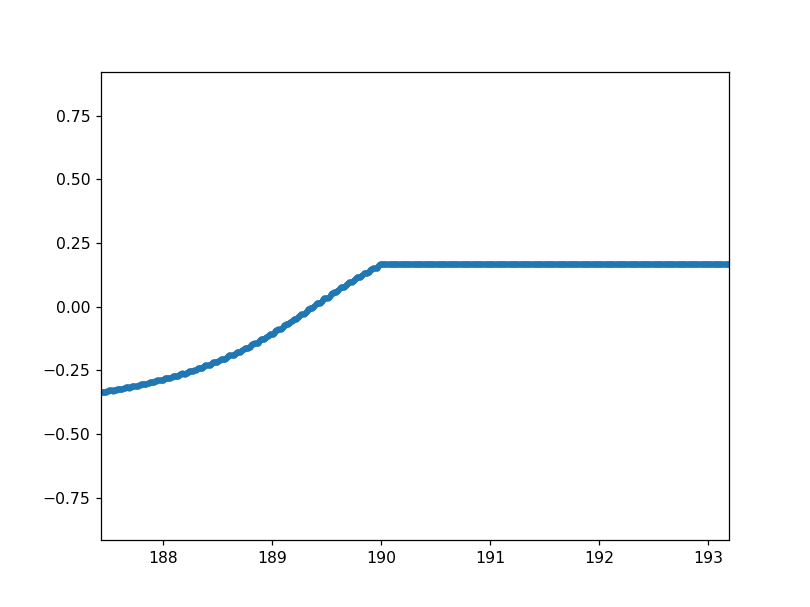

In [7]:


figure()
plot (T._Ts, phi1s/pi,'.')
#xlim (200,210)
#ylim(-2,0)
#grid()

In [8]:
def waveform_tanh (t, t_start, t_finish, th_sigma, offset,base):
    wf_rise = (np.tanh((t - 2 *th_sigma - t_start) / th_sigma)+1)/2
    wf_fall = (np.tanh((-t - 2 *th_sigma + t_finish) / th_sigma)+1)/2
    raw = wf_rise*wf_fall
    return raw/max(raw)*offset + base
def waveform_tanh_unnorm(t, t_start, t_finish, th_sigma):
    wf_rise = (np.tanh((t - 2 *th_sigma - t_start) / th_sigma)+1)/2
    wf_fall = (np.tanh((-t - 2 *th_sigma + t_finish) / th_sigma)+1)/2
    raw = wf_rise*wf_fall
    return raw
def phi_coeff (waveform,d):
    return (np.power( np.cos(waveform*pi)**2 + (d*np.sin(waveform*pi))**2 ,0.25))


<IPython.core.display.Javascript object>


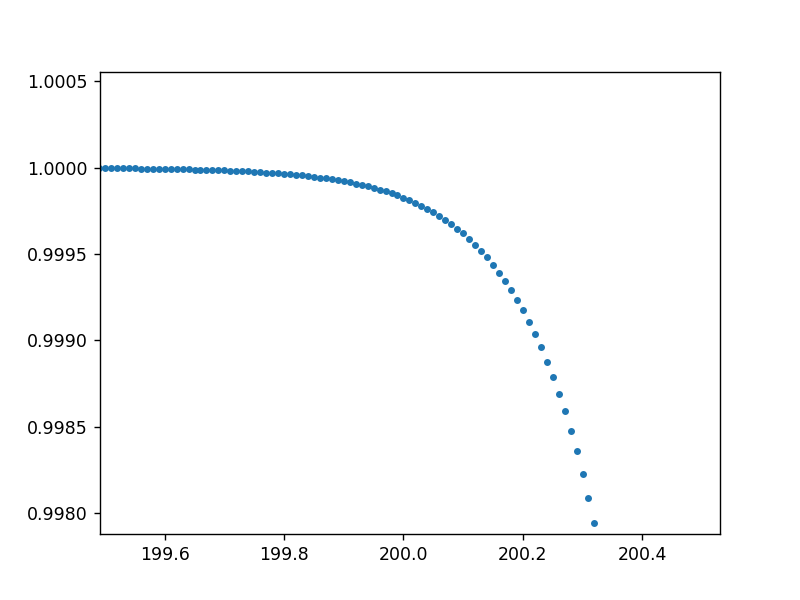

/tmp/ipykernel_1031380/4118686753.py:2: DeprecationWarning: scipy.linspace is deprecated and will be removed in SciPy 2.0.0, use numpy.linspace instead
  t = linspace (0, 600, 60001)


In [9]:
figure()
t = linspace (0, 600, 60001)
d = 0.2
waveform = waveform_tanh(t,200,260,0.5, params['phi_offset'], params['phi_base_level'])
phis = [phi_coeff (wf,d) for wf in waveform]
plot (t,phis,'.')